# Objective

The original code implementation for `get_bs_geometry` assumes the BS is above the CF pointing down at it, which is an assumption we're now breaking. The code which actually estimates the BS geometries is found within`crazyflie-lib-python/cflib/localization/lighthouse_bs_geo.py`. In this notebook, we'll go through each of the functions which are involved in estimating the pose of the BS, and try and update them to allow for a CF flipped on its side, and base stations on both the floor and ceiling. These are:

1. `_find_initial_yaw_guess` estimates yaw of the CF based on sensor order mappings
2. `_convert_yaw_to_open_cv` converts the yaw to a guess of the CF pose in the BS reference frame (but a "camera" version of the BS reference frame)
3. `_estimate_pose_by_pnp(bs_vectors, rvec_guess, tvec_guess)` uses the CF pose guess and the sensor data to solve for the actual CF pose in the BS camera reference frame, then converts that into the BS position in the world reference frame (oriented around the CF)
4. `_opencv_to_cf(rw_ocv, tw_ocv)` converts the axes of the solved pose in the world reference to the official CF reference frame axes

In this notebook we'll cover (4)

# Helper functions

In [162]:
# To run 3d interactive plots in Jupyter Lab
# conda install -c conda-forge ipympl
# conda install -c conda-forge nodejs
# jupyter labextension install @jupyter-widgets/jupyterlab-manager jupyter-matplotlib

%matplotlib widget

from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import
import matplotlib.pyplot as plt
import numpy as np


def hash_sensor_order(order):
    hash = 0
    for i in range(4):
        hash += order[i] * 4 ** i
    return hash


def show_pose(t_vec, r_matrix=None):
    
    fig = plt.figure(figsize=(8, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlim3d(-4, 4)
    ax.set_ylim3d(-4, 4)
    ax.set_zlim3d(-4, 4)
    
    if t_vec is not None:
        # Plot geom
        point = (t_vec[0], t_vec[1], t_vec[2])
        ax.scatter(*point, marker='o', s=100)
        ax.text(t_vec[0], t_vec[1], t_vec[2] + 0.1, "CF", size=20, zorder=1)
        
        # Plot BS
        point = (0, 0, 0)
        ax.text(0, 0, 0.1, "BS", size=20, zorder=1)
        
        if r_matrix is not None:
            # Plot CF axes of rotation
            # X
            ax.plot3D([t_vec[0], t_vec[0] + r_matrix[0, 0]], [t_vec[1], t_vec[1] + r_matrix[1, 0]], [t_vec[2], t_vec[2] + r_matrix[2, 0]], 'red')
            # Y
            ax.plot3D([t_vec[0], t_vec[0] + r_matrix[0, 1]], [t_vec[1], t_vec[1] + r_matrix[1, 1]], [t_vec[2], t_vec[2] + r_matrix[2, 1]], 'green')
            # Z
            ax.plot3D([t_vec[0], t_vec[0] + r_matrix[0, 2]], [t_vec[1], t_vec[1] + r_matrix[1, 2]], [t_vec[2], t_vec[2] + r_matrix[2, 2]], 'blue')


    
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    
    plt.show()

In [163]:
# Example plot

import math
import numpy as np

yaw = 60

d_c = math.cos(math.radians(yaw))
d_s = math.sin(math.radians(yaw))

R_rot_y = np.array([
    [d_c, 0.0, d_s],
    [0.0, 1.0, 0.0],
    [-d_s, 0.0, d_c],
])

show_pose((2, 2, 2), R_rot_y)   # Note this will only render in a live notebook

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

# Data

Test data is from a variety of CF positions, shown in this image:

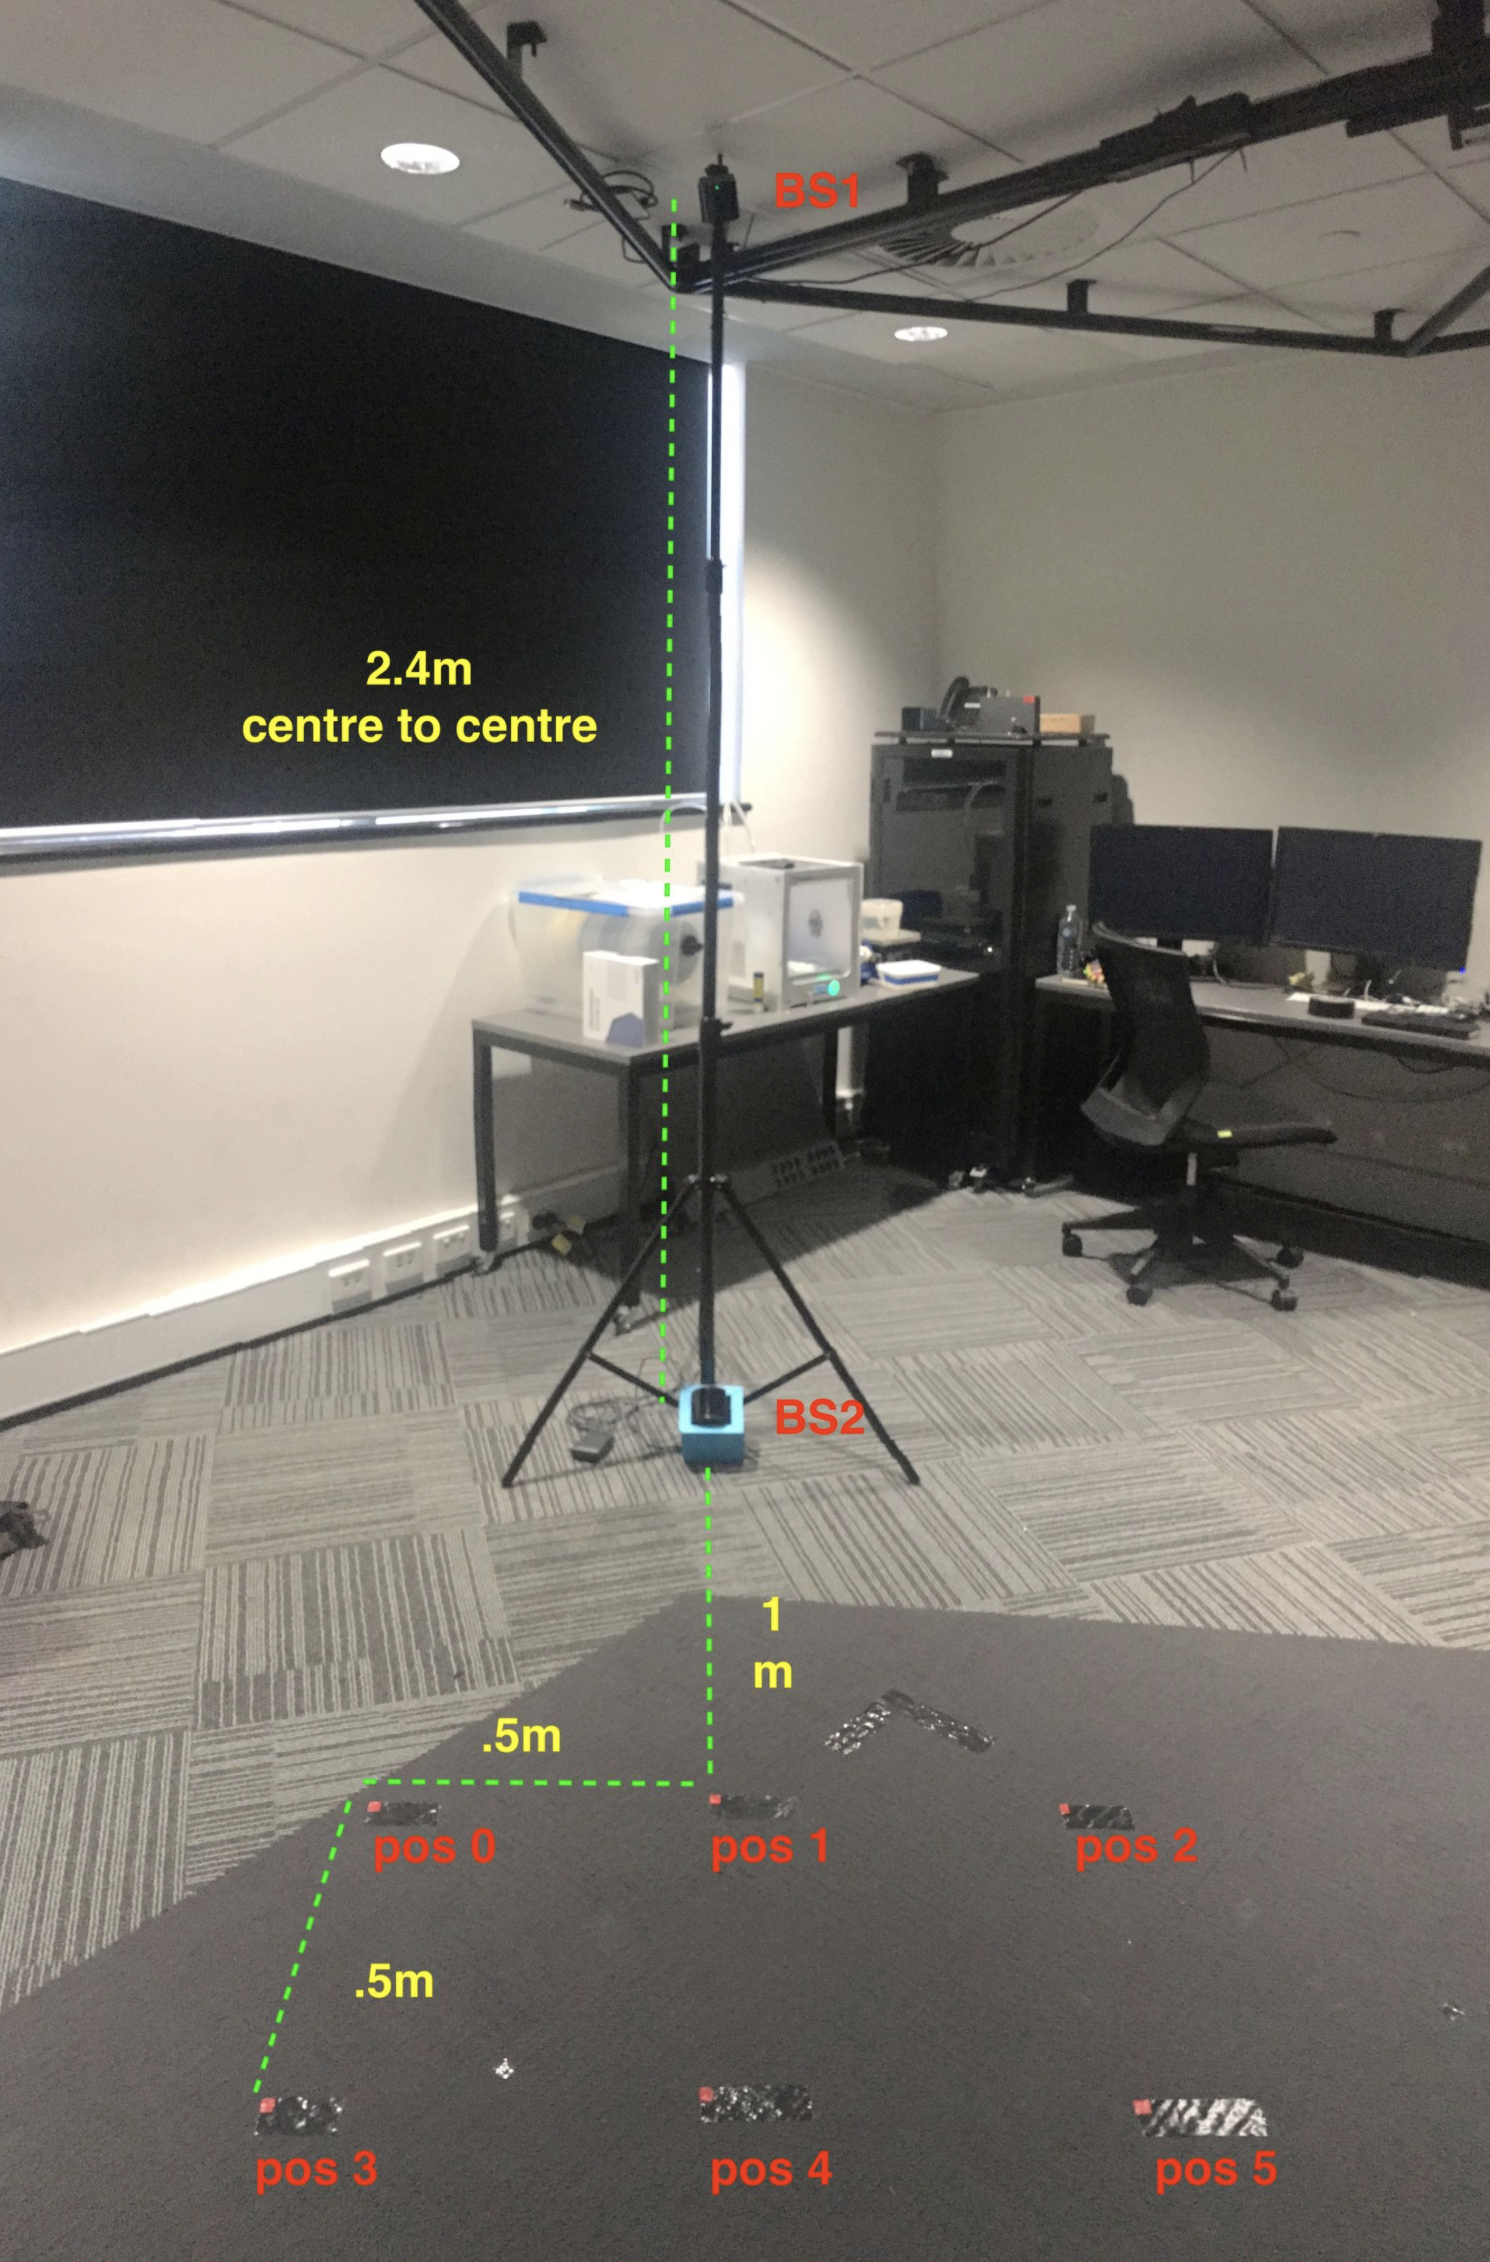

# (4) Update `_opencv_to_cf` 

This function takes the pose in the open CV camera coordinate system, and translates it into the CF reference frame.

In [19]:
def _opencv_to_cf(self, R_cv, t_cv):
    R_opencv_to_cf = np.array([
        [0.0, 0.0, 1.0],
        [-1.0, 0.0, 0.0],
        [0.0, -1.0, 0.0],
    ])

    R_cf_to_opencv = np.array([
        [0.0, -1.0, 0.0],
        [0.0, 0.0, -1.0],
        [1.0, 0.0, 0.0],
    ])

    t_cf = np.dot(R_opencv_to_cf, t_cv)
    R_cf = np.dot(R_opencv_to_cf, np.dot(R_cv, R_cf_to_opencv))

    return R_cf, t_cf